In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests 
import functools

from datetime import datetime, timedelta

fmp_api_key = os.environ['FMP_API_KEY']
polygon_api_key = os.environ['POLYGON_API_KEY']

In [23]:
sp500_historical_constituents = pd.json_normalize(requests.get(f"https://financialmodelingprep.com/api/v3/historical/sp500_constituent?apikey={fmp_api_key}").json())
sp500_historical_constituents["date"] = pd.to_datetime(sp500_historical_constituents["date"])
sp500_historical_constituents["removedTicker"] = sp500_historical_constituents["removedTicker"].replace("","N/A")
sp500_historical_constituents["addedSecurity"] = sp500_historical_constituents["addedSecurity"].replace("","N/A")
sp500_historical_constituents["announcement_date"] = sp500_historical_constituents["date"] - timedelta(days=5)

In [144]:
backtest_start_date = "2021-01-01"
deletions = sp500_historical_constituents[sp500_historical_constituents["removedTicker"] != "N/A"].copy()
deletions = deletions[(deletions["date"] >= backtest_start_date)]

additions = sp500_historical_constituents[sp500_historical_constituents["addedSecurity"] != "N/A"].copy()
additions = additions[(additions["date"] >= backtest_start_date)]

addition_tickers = additions["symbol"].values
deletion_tickers = deletions["symbol"].values

In [145]:
@functools.lru_cache(maxsize=500, typed=False)
def requests_get(url):
    return requests.get(url)

In [146]:
def index_rebalance(symbol_data, option_type):
    announcement_date = symbol_data["announcement_date"].iloc[0].strftime("%Y-%m-%d")
    effective_date = (symbol_data["date"].iloc[0]).strftime("%Y-%m-%d")
    thirty_days_after_announcement = (symbol_data["announcement_date"].iloc[0] + timedelta(days = 30)).strftime("%Y-%m-%d")
    start_date = announcement_date
    ticker = symbol_data.symbol.iloc[0]
    
    try:
        underlying_price = pd.json_normalize(requests_get(f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{thirty_days_after_announcement}?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}").json()["results"]).set_index("t")     
    except Exception as error:
        print(error)
        return None
    
    underlying_price.index = pd.to_datetime(underlying_price.index, unit = "ms", utc = True).tz_convert("America/New_York")
    underlying_price["returns"] = underlying_price["c"].pct_change().fillna(0)
    underlying_price["cumulative_returns"] = underlying_price["returns"].cumsum()
    
    effective_price = underlying_price["o"].iloc[0]
    
    options = pd.json_normalize(requests_get(f"https://api.polygon.io/v3/reference/options/contracts?underlying_ticker={ticker}&contract_type={option_type}&as_of={start_date}&expired=false&limit=1000&apiKey={polygon_api_key}").json()["results"])
    try:
        option_after_event = options[options["expiration_date"] >= (symbol_data["date"].iloc[0] + timedelta(days = 25)).strftime("%Y-%m-%d")]
        first_expiration_date_after_event = option_after_event["expiration_date"].iloc[0]
    except Exception as error:
        print(error)
        return None

    ticker_on_expiration = options[options.expiration_date == first_expiration_date_after_event].copy()
    ticker_on_expiration["distance_from_price"] = abs(ticker_on_expiration["strike_price"] - effective_price)
                    
    option = ticker_on_expiration[ticker_on_expiration["distance_from_price"] == ticker_on_expiration["distance_from_price"].min()]
    option_symbol = option["ticker"].iloc[0]
    
    try:
        option_ohlcv = pd.json_normalize(requests_get(f"https://api.polygon.io/v2/aggs/ticker/{option_symbol}/range/1/day/{start_date}/{first_expiration_date_after_event}?adjusted=true&sort=asc&limit=50000&apiKey={polygon_api_key}").json()["results"]).set_index("t")
    except Exception as error:
        print(error)
        return None
    
    
    option_ohlcv.index = pd.to_datetime(option_ohlcv.index, unit = "ms", utc = True).tz_convert("America/New_York")
    
    open_price = option_ohlcv["o"].iloc[0]
    last_price = option_ohlcv["c"].iloc[-1]
    
    trade_dataframe = pd.DataFrame([{"effective_date": effective_date, "open_price": open_price,
                                     "last_price": last_price, "ticker": ticker, 
                                     "reason": symbol_data["reason"].iloc[0]}])

    return trade_dataframe


In [184]:
deletion_list = []

for ticker in deletion_tickers:
    symbol_data = deletions[deletions["symbol"] == ticker].copy()
    deletion_list.append(index_rebalance(symbol_data, "put"))

'results'
'results'
'results'
'results'
'expiration_date'
'results'
'results'
'results'
'results'
'results'
'results'
'results'


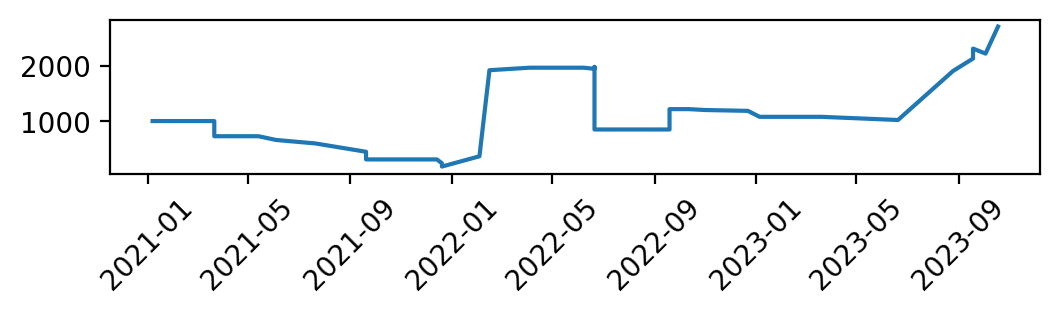

In [169]:
full_deletion_data = pd.concat(deletion_list).sort_values(by = "effective_date", ascending = True).set_index("effective_date")
full_deletion_data.index = pd.to_datetime(full_deletion_data.index)
full_deletion_data = full_deletion_data[full_deletion_data["ticker"] != "SBNY"]
full_deletion_data["gross_pnl"] = full_deletion_data["last_price"] - full_deletion_data["open_price"]
full_deletion_data["capital"] = 1000 + (full_deletion_data["gross_pnl"].cumsum() * 100)

plt.figure(dpi = 200, figsize=(6,  1))
plt.xticks(rotation = 45)
plt.plot(full_deletion_data["capital"])
plt.show()

In [149]:
addition_list = []

for ticker in addition_tickers:
    symbol_data = additions[additions["symbol"] == ticker].copy()
    addition_list.append(index_rebalance(symbol_data, "call"))

'expiration_date'
'expiration_date'
'expiration_date'
'results'
'expiration_date'
'expiration_date'
'results'
'expiration_date'


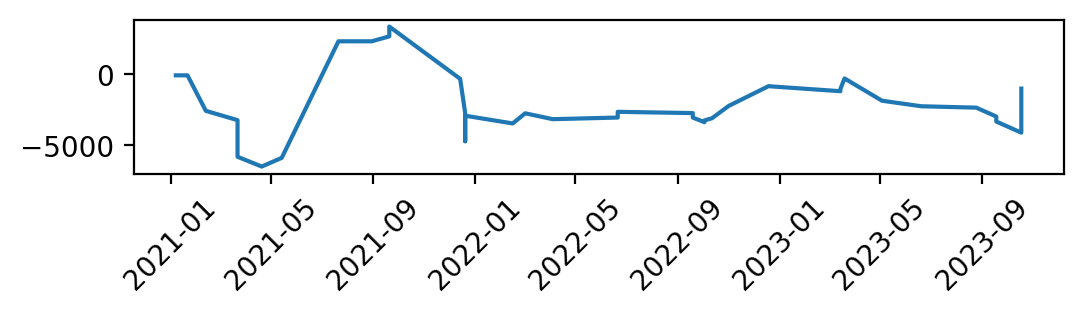

In [170]:
full_addition_data = pd.concat(addition_list).sort_values(by = "effective_date", ascending = True).set_index("effective_date")
full_addition_data.index = pd.to_datetime(full_addition_data.index)
full_addition_data["gross_pnl"] = full_addition_data["last_price"] - full_addition_data["open_price"]
full_addition_data["capital"] = 1000 + (full_addition_data["gross_pnl"].cumsum() * 100)

plt.figure(dpi = 200, figsize=(6,  1))
plt.xticks(rotation = 45)
plt.plot(full_addition_data["capital"])
plt.show()


<Axes: xlabel='effective_date'>

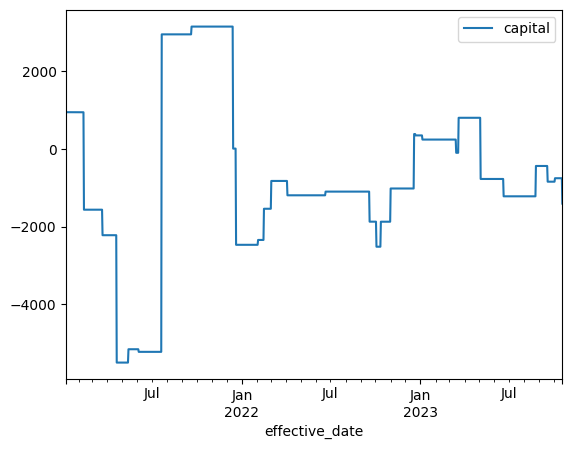

In [183]:
(full_deletion_data[['capital']].resample('1d').first().ffill() + full_addition_data[['capital']].resample('1d').first().ffill()).plot()